# pressure

this notebook annotates high and low pressure centers. the algorithm:

1) find the max pressure (or height)
2) annotate it with an H
3) mask out a circle or radius R around it
4) select the maximum value again
5) if the maximum value is almost exactly "R" from the previous value, discard it and expand the circle
6) if the maximum is a new local max, mark it with an H
7) terminate after n centres found, or m false centers rejected
8) repeat for low pressure centers, marking them with L's

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import (
    clear_directory,
    get_var,
    plot_cities,
    make_figure,
    make_title,
)

%load_ext jupyter_black

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
now = pd.Timestamp.utcnow().floor("6h").tz_localize(None)

In [356]:
ds = get_var(now, "gdps", 3, "PRMSL", "MSL_0")
ds["prmsl"] /= 100

✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-15 12:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


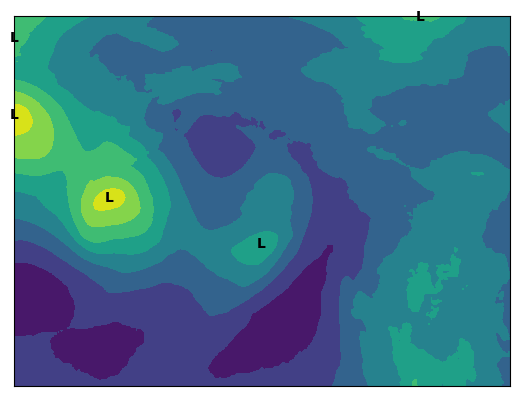

In [415]:
pres = np.array(ds.prmsl) * -1
presprime = pres.copy()
radius = 40  # pixels
delrad = 20
aspect = pres.shape[1] / pres.shape[0]
mark = "L"

# generate the figure
fig, ax = plt.subplots()
ax.set_xticks(ticks=[], labels=([]))
ax.set_yticks(ticks=[], labels=([]))

# get the index of the max value
ymax, xmax = np.unravel_index(np.nanargmax(pres), pres.shape)

# mark it
ax.text(xmax, ymax, mark, ha="center", va="center")

# mask out all values within radius of the max
x = np.arange(0, np.shape(pres)[1])
y = np.arange(0, np.shape(pres)[0])
mask = ((x[np.newaxis, :] - xmax) / aspect) ** 2 + (
    (y[:, np.newaxis] - ymax)
) ** 2 < radius**2
pres[mask] = np.nan

n = 0  # number of centres marked
m = 0  # number of false centres located
while (n < 10) and (m < 2):
    # repeat the operation
    # get the index of the max value
    ymaxp, xmaxp = np.unravel_index(np.nanargmax(pres), pres.shape)

    # check to see if the new max is on the border of the masked area (+ 10 pixels)
    falseextrema = bool(
        ((xmaxp - xmax) / aspect) ** 2 + ((ymax - ymax)) ** 2 < (radius + 10) ** 2
    )

    # if the new centre is next to the old one, ignore it and increase radius
    if falseextrema:
        m += 1
        mask = ((x[np.newaxis, :] - xmaxp) / aspect) ** 2 + (
            (y[:, np.newaxis] - ymaxp)
        ) ** 2 < (radius + delrad) ** 2
        pres[mask] = np.nan
        ymaxp, xmaxp = np.unravel_index(np.nanargmax(pres), pres.shape)

    ax.text(xmaxp, ymaxp, mark, ha="center", va="center")
    n += 1
    mask = ((x[np.newaxis, :] - xmaxp) / aspect) ** 2 + (
        (y[:, np.newaxis] - ymaxp)
    ) ** 2 < radius**2
    pres[mask] = np.nan

    # reset the max indices
    xmax = xmaxp
    ymax = xmaxp


ax.contourf(presprime)

In [349]:
def find_pressure_centres(pres, radius, delrad):
    """
    Andrew's experimental function to locate and label pressure
    centres.

    inputs:
    -------
    pres: (np.array) the pressure field to operate on.

    radius: (pixels)    the characteristic length scale of the centre.
                     suggest 90pi for high pressure on GDPS data,
                     50pi for low pressure on GDPS.
    delrad: (pixels) step to take when searching past false centre
                     candidates.
                     suggest 50pi for high pressure GPDS,
                     30pi for low pressure GDPS.
    returns:
    --------
    centres (list of tuples) the pressure centres
    """
    # fill lists with H and L coordinates (pixels)
    centres = []

    # get the aspect ratio
    aspect = pres.shape[1] / pres.shape[0]

    # get the index of the max value and save it
    ymax, xmax = np.unravel_index(np.nanargmax(pres), pres.shape)
    centres.append((int(xmax), int(ymax)))

    # mask out all values within radius of the max
    x = np.arange(0, np.shape(pres)[1])
    y = np.arange(0, np.shape(pres)[0])
    mask = ((x[np.newaxis, :] - xmax) / aspect) ** 2 + (
        (y[:, np.newaxis] - ymax)
    ) ** 2 < radius**2
    pres[mask] = np.nan

    n = 0  # number of centres marked
    m = 0  # number of false centres located
    while (n < 10) and (m < 2):
        # get the index of the new max value
        ymaxp, xmaxp = np.unravel_index(np.nanargmax(pres), pres.shape)

        # check to see if the new max is on the border of the masked area (+ 5 pixels)
        falseextrema = bool(
            ((xmaxp - xmax) / aspect) ** 2 + ((ymax - ymax)) ** 2 < (radius + 5) ** 2
        )

        # if the new centre is next to the old one, ignore it, increase radius by
        # delrad, and try again until a true centre is found
        if falseextrema:
            m += 1
            mask = ((x[np.newaxis, :] - xmaxp) / aspect) ** 2 + (
                (y[:, np.newaxis] - ymaxp)
            ) ** 2 < (radius + delrad) ** 2
            pres[mask] = np.nan
            ymaxp, xmaxp = np.unravel_index(np.nanargmax(pres), pres.shape)

        # once a true centre is found, save it and iterate n
        centres.append((int(xmaxp), int(ymaxp)))
        n += 1

        # mask the new centre
        mask = ((x[np.newaxis, :] - xmaxp) / aspect) ** 2 + (
            (y[:, np.newaxis] - ymaxp)
        ) ** 2 < radius**2
        pres[mask] = np.nan

        # reset the max indices
        xmax = xmaxp
        ymax = xmaxp

    return centres

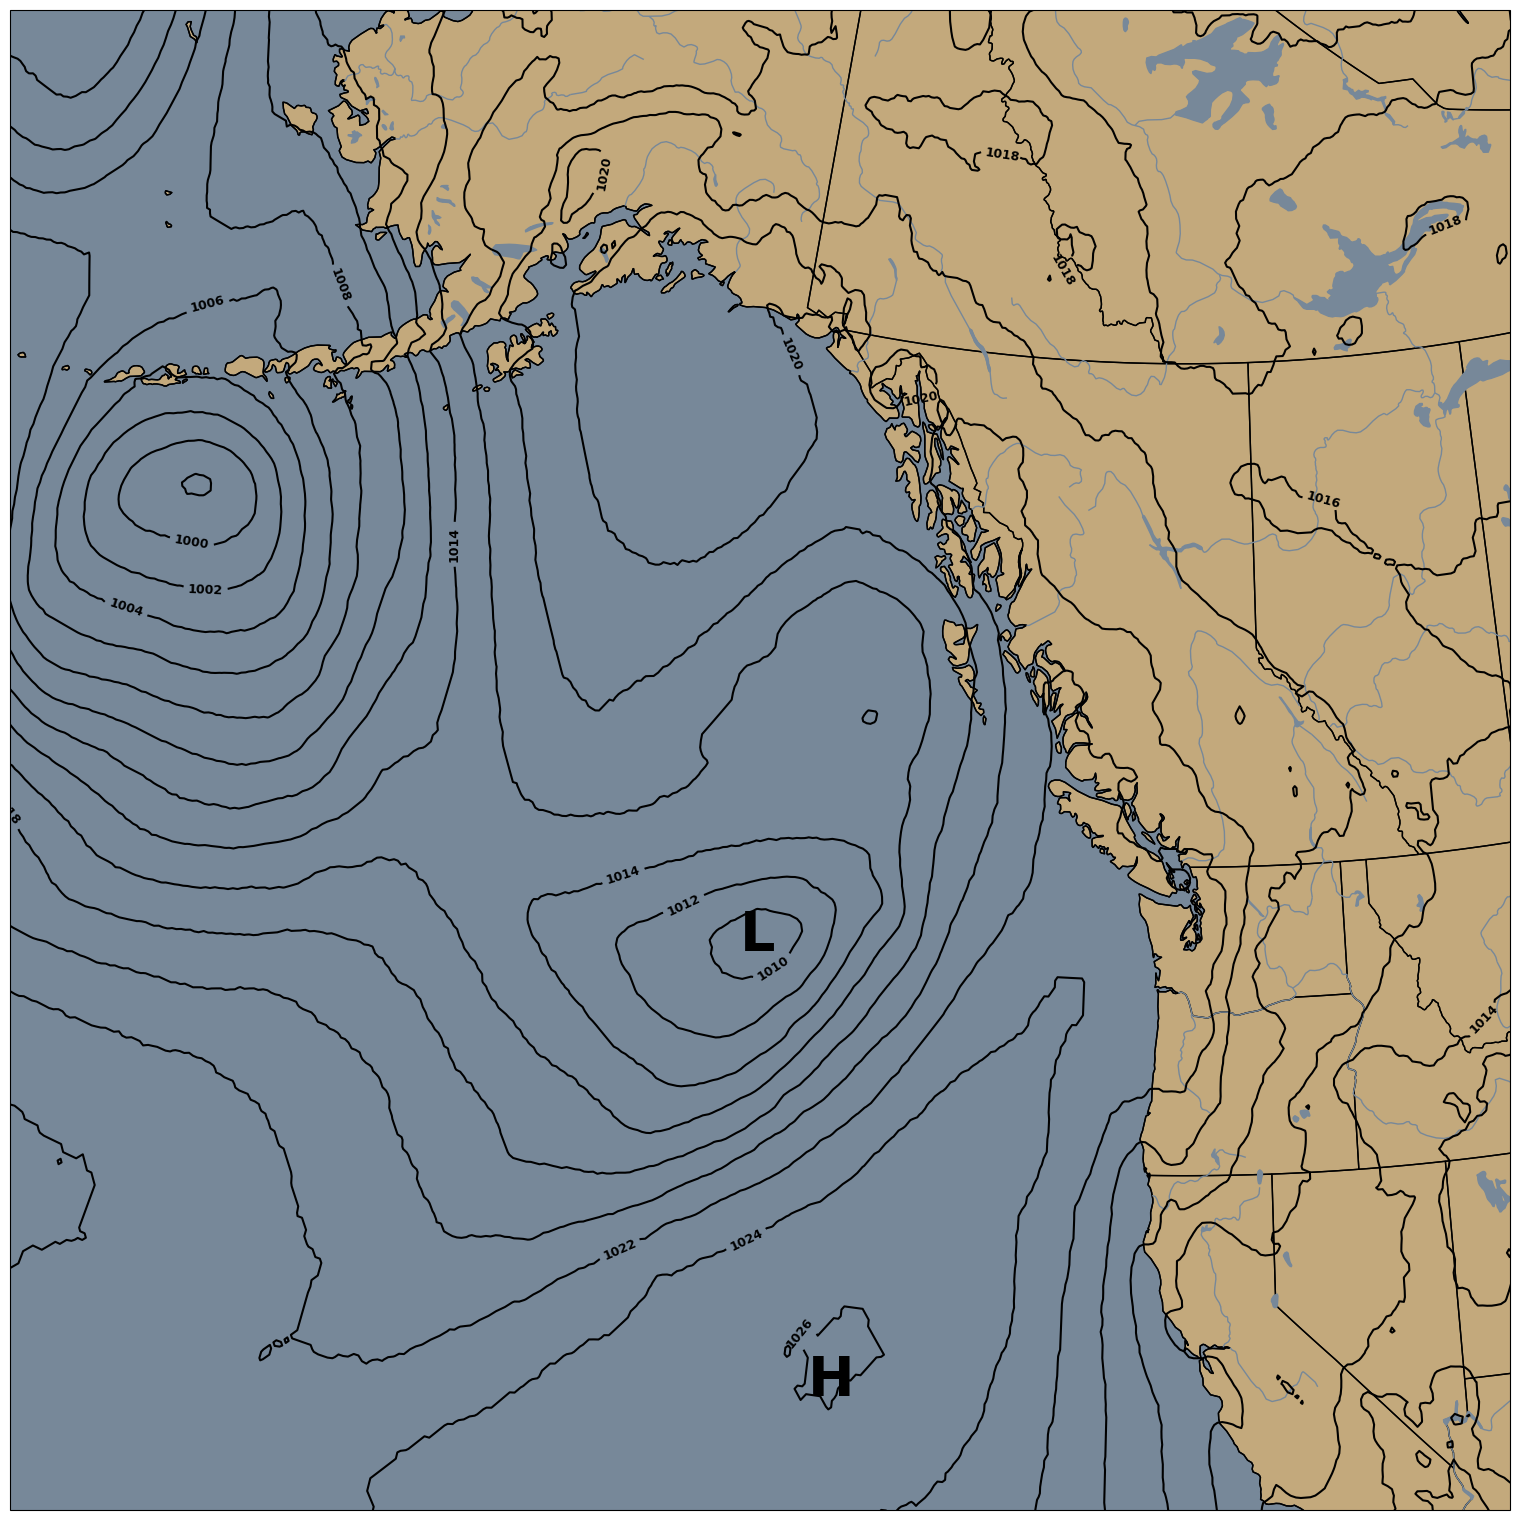

In [435]:
extent = "MWF"
fig, ax = make_figure(extent=extent)


def plot_pressure(da, ax, extent, levels=range(900, 1100, 2)):
    """
    plots pressure contours, highs, lows on an existing axis

    da (xarray dataarray (e.g. ds.prmsl)) the pressure field

    ax (matplotlib axis) the axis on which to plot

    extent (str) one of "MWF", "Alberta Rockies", "South Coast",
                 "South Interior", "BC-AB"

    levels (range) levels to contour plot
    """
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        da,
        colors="k",
        transform=pc,
        levels=levels,
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # find high and low pressures
    highs = find_pressure_centres(np.array(ds.prmsl), 100, 50)
    lows = find_pressure_centres(np.array(ds.prmsl) * -1, 50, 30)

    # truncate pressure center to map extent and plot
    with open("../config/map_extents.json", "r") as f:
        map_extents = json.load(f)
    ext = map_extents[extent]
    for low in lows:
        lat = da[low[1], low[0]].latitude
        lon = da[low[1], low[0]].longitude
        if (ext[0] < lon) & (lon < ext[1]) & (ext[2] < lat) & (lat < ext[3]):
            ax.text(lon, lat, "L", size=40, transform=pc, ha="center", va="center")

    for high in highs:
        lat = da[high[1], high[0]].latitude
        lon = da[high[1], high[0]].longitude
        if (ext[0] < lon) & (lon < ext[1]) & (ext[2] < lat) & (lat < ext[3]):
            ax.text(lon, lat, "H", size=40, transform=pc, ha="center", va="center")

    return None


plot_pressure(ds.prmsl, ax, extent)
fig.show()